<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.981 · TFM Àrea 4 · NLP & Text Mining</p>
<p style="margin: 0; text-align:right;">2022 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="row" style="padding-top: 50px;">
    <div class="row" style="background: #494949;padding: 10px 20px; color: #FFF">
        <div class="col-md-12">
            <div style="text-align:left;"><b>Estudiant:</b> Albert Cámara Viñals</div>
        </div>
    </div>
</div>

## T6 - Information Extraction from *synthetic invoice dataset* with *LayoutLMv2* model

## **Information extraction**

> Information extraction (IE) is the task of automatically extracting structured information from unstructured and/or semi-structured machine-readable documents and other electronically represented sources. In most of the cases this activity concerns processing images by means computer vision (CV) and processing human language texts by means of natural language processing (NLP).

In [1]:
# Load libraries
import cv2
import glob
import pandas as pd
import pickle
import math
import networkx as nx
import numpy as np
import os
import torch
import re
import seaborn as sns
import shutil
import warnings

from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from torch.utils.data import Dataset, DataLoader

from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification, AdamW
from transformers import logging

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

logging.set_verbosity_error()
warnings.filterwarnings("ignore")

## Data Objects

### Define some data models

In [2]:
class InvoiceDataset(Dataset):
    """Invoice dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (dataframe): Dataframe containing the word-level annotations (filename, words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.image_file_names = annotations['file'].tolist()
        self.words = annotations['words'].tolist() 
        self.labels = annotations['labels'].tolist() 
        self.boxes = annotations['boxes'].tolist()
        self.image_dir = image_dir
        self.processor = processor
        
        #print(len(self.image_file_names), ' ', len(self.words), ' ', len(self.labels), ' ', len(self.boxes))

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
          
        # word_labels = [label2id[label] for label in word_labels]
        
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, padding="max_length", truncation=True, return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

### Define some functions

In [3]:
def normalize_bbox(x1, y1, x3, y3, width, height):
    bbox = [
        int(1000 * (x1 / width)),
        int(1000 * (y1 / height)),
        int(1000 * (x3 / width)),
        int(1000 * (y3 / height)),
    ]
    
    return bbox

In [4]:
def unnormalize_bbox(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [5]:
def process_file_to_layoutlmv2_data(filepath):
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    basename = os.path.splitext(filename)[0]
    
    # Read dataframe
    df = pd.read_csv(filepath, sep=';')
        
    # Delete rows with text outside of page
    df = df[df['x1'] > 0]
    df = df[df['x3'] < df['page_width']]
    #df = df[df['y3'] < df['page_height']]
    
    # Delete rows with null content and reset index
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    df['normalize_bbox'] = df.apply((lambda x: normalize_bbox(x['x1'], x['y1'], x['x3'], x['y3'], x['page_width'], x['page_height'])),axis=1)
    df['tag_id'] = df.apply(lambda x: label2id.get(x['tag']), axis=1)
    
    words = df['contents'].tolist()
    boxes = df['normalize_bbox'].tolist()
    labels = df['tag_id'].tolist()
    
    return words, labels, boxes

In [6]:
def preprocess_subset_data(df, dataset_path, transfomed_data_path, subsetname):
    print('Preprocessing data for: ', subsetname)
    
    df = df.sort_values(by=['file'])
    
    # Creating an empty Dataframe with column names only
    df_annotations = pd.DataFrame(columns=['file', 'words', 'labels', 'boxes'])
    
    dst_path = os.path.join(dataset_path, subsetname, 'image')
    
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
            
    words = [] 
    labels = []
    boxes = []

    for index, row in df.iterrows():
        file = row['file']
        image = row['image']
        provider = row['provider']
        #print(file, image, provider)

        shutil.copy(os.path.join(transfomed_data_path, provider, image), dst_path)

        words, labels, boxes = process_file_to_layoutlmv2_data(os.path.join(transfomed_data_path, provider, file))

        df_annotations = df_annotations.append({'file': image, 'words': words, 'labels': labels, 'boxes': boxes}, ignore_index=True)
    
    # df_annotations = df_annotations.sort_values(by=['file'])
    
    # Save all documents annotations to file 
    df_annotations.to_pickle(os.path.join(dataset_path, subsetname +'_df.pkl'))

In [7]:
def process_prediction_results(preds, out_label_ids, labels):
    preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != -100:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    return out_label_list, preds_list

**Define work directories**

In [8]:
# Define some directories
work_dir = './models/'
data_dir = './data/'
dataset_path = './data/synthetic_invoice/'
transfomed_data_path = './data/synthetic_invoice/transformed/'

**Load a dictionary of Entity attributes**

In [9]:
invoice_attributes_file = open(os.path.join(data_dir, 'invoice_attributes.pickle'), "rb")
invoice_attributes = pickle.load(invoice_attributes_file)
invoice_attributes_file.close()

tags = [v['tag'] for k, v in invoice_attributes.items()]

tags.sort()

id2label = {v: k for v, k in enumerate(tags)}
label2id = {k: v for v, k in enumerate(tags)}

print('Number of labels:', len(label2id.keys()))

Number of labels: 40


## Modeling

### Data preparation to load into LayoutLMv2 model (process all files)

In [10]:
# Explore sample dataframe (document_type, file_name)
samples_list = pd.read_csv(os.path.join(dataset_path, 'samples_list.csv'), dtype=str, sep=';')
samples_list.head()

,type,file,image,pdf,gedi,provider,words
0,invoice,amazon-1.csv,amazon-1.tiff,amazon-1.pdf,amazon-1.xml,amazon,169
1,invoice,amazon-10.csv,amazon-10.tiff,amazon-10.pdf,amazon-10.xml,amazon,183
2,invoice,amazon-100.csv,amazon-100.tiff,amazon-100.pdf,amazon-100.xml,amazon,195
3,invoice,amazon-101.csv,amazon-101.tiff,amazon-101.pdf,amazon-101.xml,amazon,173
4,invoice,amazon-102.csv,amazon-102.tiff,amazon-102.pdf,amazon-102.xml,amazon,205


#### Split dataset into train-val-test sets

In [11]:
# Get list of providers
providers =  samples_list['provider'].values

# Split dataset into train-test sets preserving the representation of each provider
train_samples, test_samples = train_test_split(samples_list, test_size=0.20, random_state=0, stratify=providers)

# Get list of providers
providers =  train_samples['provider'].values

# Split dataset into train-test sets preserving the representation of each provider
train_samples, val_samples = train_test_split(train_samples, test_size=0.50, random_state=0, stratify=providers)

# Show sets size
print('Train size:', train_samples.shape)
print('Validation size:', val_samples.shape)
print('Test size:', test_samples.shape)

Train size: (700, 7)
Validation size: (700, 7)
Test size: (350, 7)


In [12]:
# Preprocess data of each subset & save to file
preprocess_subset_data(train_samples, dataset_path, transfomed_data_path, 'train')
preprocess_subset_data(val_samples, dataset_path, transfomed_data_path, 'val')
preprocess_subset_data(test_samples, dataset_path, transfomed_data_path, 'test')

Preprocessing data for:  train
Preprocessing data for:  val
Preprocessing data for:  test


In [13]:
# Load preprocessed data for each subset from a file
train = pd.read_pickle(os.path.join(dataset_path, 'train_df.pkl'))
val = pd.read_pickle(os.path.join(dataset_path, 'val_df.pkl'))
test = pd.read_pickle(os.path.join(dataset_path, 'test_df.pkl'))

**Create subset Datasets**

In [14]:
# Load LayoutLMv2Processor from Huggingface provided by Microsoft
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

# Create PyTorch Dataset for each subset 
train_dataset = InvoiceDataset(annotations=train, image_dir=os.path.join(dataset_path, 'train/image/'), processor=processor)
val_dataset = InvoiceDataset(annotations=val, image_dir=os.path.join(dataset_path, 'val/image/'), processor=processor)
test_dataset = InvoiceDataset(annotations=test, image_dir=os.path.join(dataset_path, 'test/image/'), processor=processor)

**Create dataloaders**

In [15]:
# Create PyTorch DataLoader for each subset 
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1)

## Training and Model performance plots

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).

In [16]:
# Load Pretrained Model of LayoutLMv2
model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased', num_labels=len(tags))

# Get PyTorch device if available witH GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #

# Load Model to device
model.to(device)

# Declaring Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training with Validation
epochs = 4
min_val_loss = np.inf
global_step = 0

for epoch in range(epochs):  
    print("Epoch:", epoch)
    
    train_loss = 0.0
    
    # Put the model in training mode
    model.train() 

    for batch in tqdm(train_dataloader):
        # Transfer Data to device
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize Pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels) 
        
        # Find the loss
        loss = outputs.loss
        
        # Print loss every 100 steps
        if global_step % 100 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        # Calculate gradients
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
        # Calculate Loss
        train_loss += loss.item()
        
        # Increase step counter
        global_step += 1

    val_loss = 0.0
    
    # Put the model in evaluation mode
    model.eval() 
    
    for batch in tqdm(val_dataloader):
        # Transfer Data to device
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward + backward + optimize Pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels) 
        
        # Find the loss
        loss = outputs.loss
                
        # Calculate Loss
        val_loss += loss.item()
        
    print(f'Epoch {epoch} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {val_loss / len(val_dataloader)}')
     
    if min_val_loss > val_loss:
        print(f'Validation Loss Decreased ({min_val_loss:.6f} ---> {val_loss:.6f}) \t\t Saving The Model')
        print()
        
        min_val_loss = val_loss
         
        # Saving State Dict
        torch.save(model, os.path.join(work_dir, 'fine-tuned_layoutlmv2_model.pth'))

#model.save_pretrained(os.path.join(dataset_path, 'checkpoints'))

Epoch: 0


  0%|          | 0/700 [00:00<?, ?it/s]

Loss after 0 steps: 3.669982671737671
Loss after 100 steps: 2.430917978286743
Loss after 200 steps: 1.565852165222168
Loss after 300 steps: 1.1916794776916504
Loss after 400 steps: 0.7503442764282227
Loss after 500 steps: 0.3855343163013458
Loss after 600 steps: 0.669604480266571


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 0 		 Training Loss: 1.2268482311708586 		 Validation Loss: 0.47333911252873284
Validation Loss Decreased (inf ---> 331.337379) 		 Saving The Model

Epoch: 1


  0%|          | 0/700 [00:00<?, ?it/s]

Loss after 700 steps: 0.8115969300270081
Loss after 800 steps: 0.5157843232154846
Loss after 900 steps: 0.14171768724918365
Loss after 1000 steps: 0.12406052649021149
Loss after 1100 steps: 0.33128106594085693
Loss after 1200 steps: 0.11598090827465057
Loss after 1300 steps: 0.07246024161577225


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 0.21360959048782077 		 Validation Loss: 0.09778857891048703
Validation Loss Decreased (331.337379 ---> 68.452005) 		 Saving The Model

Epoch: 2


  0%|          | 0/700 [00:00<?, ?it/s]

Loss after 1400 steps: 0.1624816656112671
Loss after 1500 steps: 0.06491995602846146
Loss after 1600 steps: 0.03848513960838318
Loss after 1700 steps: 0.12018431723117828
Loss after 1800 steps: 0.03916812688112259
Loss after 1900 steps: 0.03399025648832321
Loss after 2000 steps: 0.059285376220941544


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 2 		 Training Loss: 0.05889203685468861 		 Validation Loss: 0.04074355757795274
Validation Loss Decreased (68.452005 ---> 28.520490) 		 Saving The Model

Epoch: 3


  0%|          | 0/700 [00:00<?, ?it/s]

Loss after 2100 steps: 0.03255092725157738
Loss after 2200 steps: 0.07774164527654648
Loss after 2300 steps: 0.017153767868876457
Loss after 2400 steps: 0.01932646334171295
Loss after 2500 steps: 0.020361868664622307
Loss after 2600 steps: 0.04138388857245445
Loss after 2700 steps: 0.010235189460217953


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 3 		 Training Loss: 0.032913116364340696 		 Validation Loss: 0.015347235635854304
Validation Loss Decreased (28.520490 ---> 10.743065) 		 Saving The Model



## Evaluate the model

**Test Set**

In [17]:
# Load saved Model
model = torch.load(os.path.join(work_dir, 'fine-tuned_layoutlmv2_model.pth'))

In [18]:
# Load preprocessed data for Test subset from a file
test = pd.read_pickle(os.path.join(dataset_path, 'test_df.pkl'))

In [19]:
# Load LayoutLMv2Processor from Huggingface provided by Microsoft
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

# Create PyTorch Dataset for Test subset 
test_dataset = InvoiceDataset(annotations=test, image_dir=os.path.join(dataset_path, 'test/image/'), processor=processor)

In [20]:
# Create PyTorch DataLoader for Test subset 
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [21]:
preds_val = None
out_label_ids = None

# Get PyTorch device if available witH GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Put model in evaluation mode
model.eval()

for batch in tqdm(test_dataloader, desc="Evaluating"):

    with torch.no_grad():
        # Transfer Data to device
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        
        # Get predictions
        if preds_val is None:
            preds_val = outputs.logits.detach().cpu().numpy()
            out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
            preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)

Evaluating:   0%|          | 0/350 [00:00<?, ?it/s]

In [22]:
# Process model prediction results
out_label_list, preds_list = process_prediction_results(preds_val, out_label_ids, tags)

# Get predictions & true targets
predictions = np.concatenate(preds_list)
true_targets = np.concatenate(out_label_list)

# Calculate some metrics: precision, recall i f1-score by class on Test Set.
print('\n Mètriques precision, recall i f1-score obtingudes per classe \n')
print(classification_report(true_targets, predictions))


 Mètriques precision, recall i f1-score obtingudes per classe 

                                 precision    recall  f1-score   support

                BILLING_ADDRESS       1.00      1.00      1.00      2294
                   BILLING_NAME       1.00      1.00      1.00       813
                  CLIENT_NUMBER       1.00      0.99      1.00       150
                          IMAGE       1.00      1.00      1.00       100
                   INVOICE_DATE       1.00      1.00      1.00      1335
                 INVOICE_NUMBER       0.98      1.00      0.99       468
                   ORDER_NUMBER       1.00      1.00      1.00       350
                          OTHER       1.00      1.00      1.00     34196
                   PAYMENT_MODE       0.97      1.00      0.99       215
            PRODUCT_DESCRIPTION       1.00      1.00      1.00      5969
                  PRODUCT_TOTAL       1.00      1.00      1.00       278
PRODUCT_TOTAL_PRICE_WITHOUT_TAX       1.00      1.00      


Matriu de confusió


Text(177.0, 0.5, 'Real')

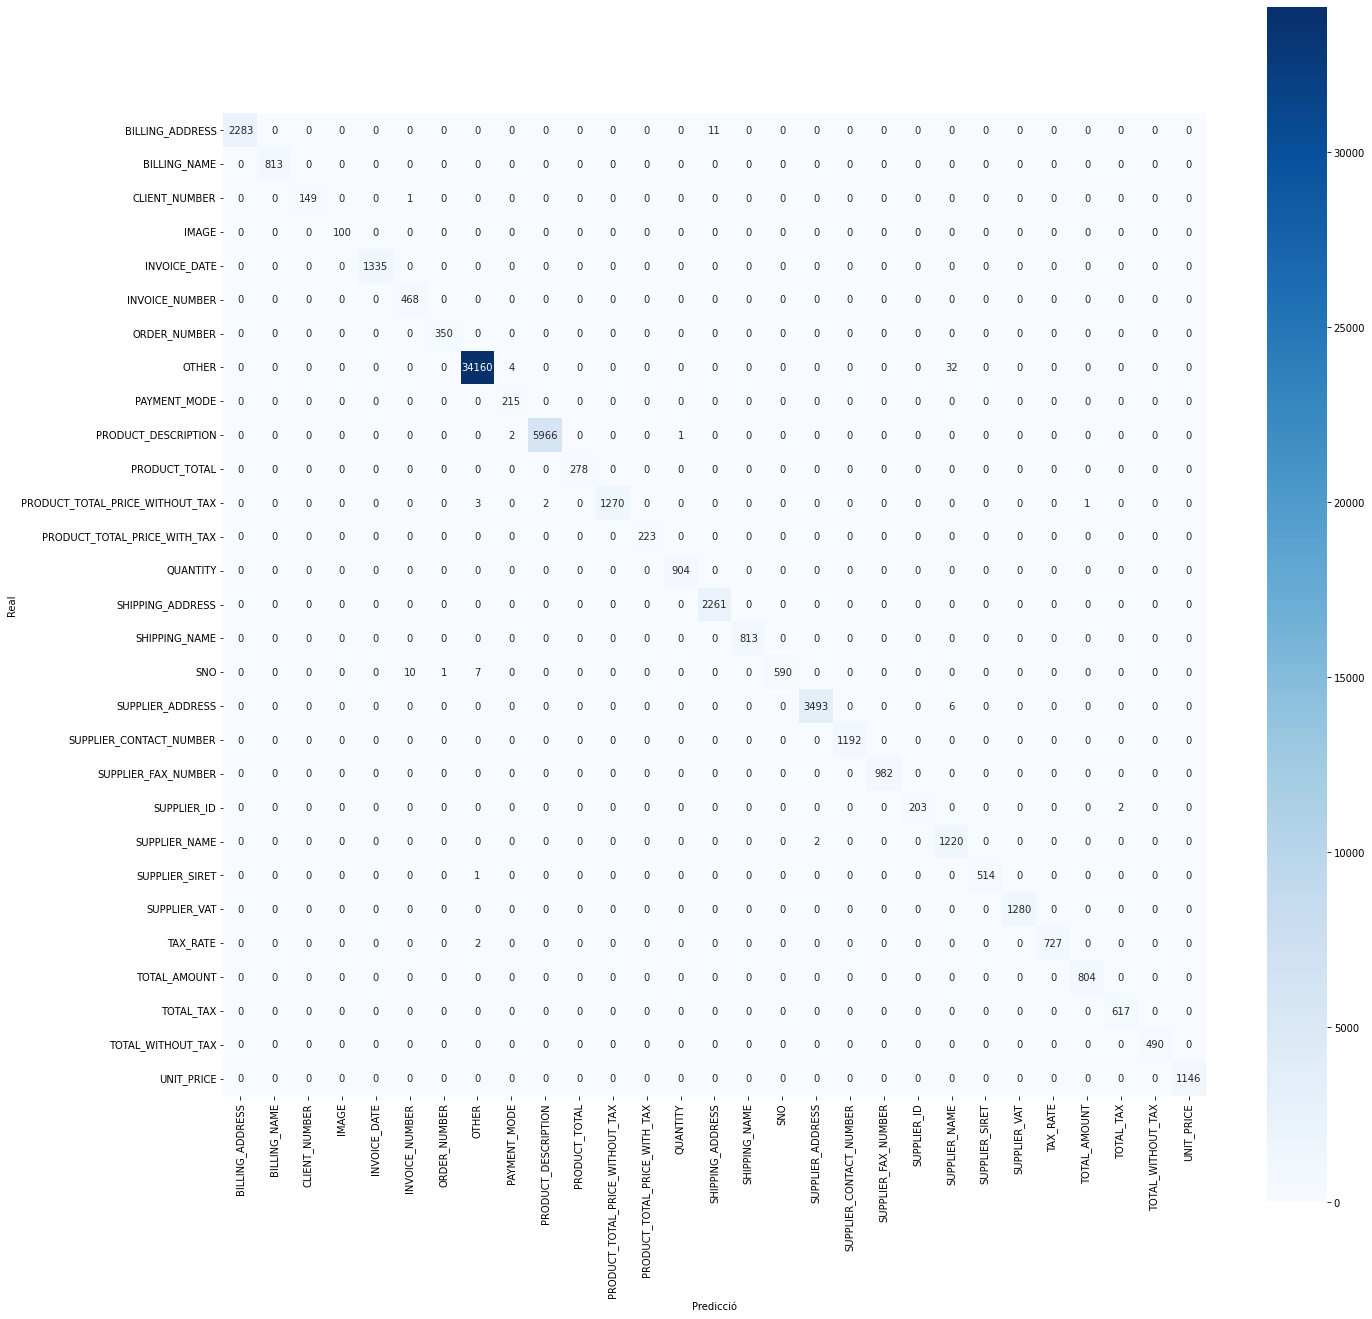

In [23]:
# Visualize confusion matrix
print('\nMatriu de confusió')
matrix = confusion_matrix(true_targets, predictions)

targets = [id2label[id] for id in set(np.concatenate(test['labels']))]

plt.figure(figsize=(22, 22))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
ax.set_xticklabels(targets, rotation = 90, size = 10)
ax.set_yticklabels(targets, rotation = 0, size = 10)
plt.xlabel("Predicció")
plt.ylabel("Real")

## Making predictions with the model

**Single prediction**

In [24]:
# Define a samle index
sample_idx = 0

# Get Encodings for sample_idx
encoding = test_dataset[sample_idx]

# Get PyTorch device if available witH GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Load encodings to device
for k,v in encoding.items():
    encoding[k] = v.unsqueeze(0).to(device)

# Put model in evaluation mode
model.eval()

# Make predictions
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'], token_type_ids=encoding['token_type_ids'], bbox=encoding['bbox'], image=encoding['image'])

In [25]:
# Transform model output to predictions
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
ground_truth_labels = [id2label[label] for label in encoding['labels'].squeeze().tolist() if label != -100]
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]

# Check number of results
print('Ground truth targets:', len(ground_truth_labels))
print('Predicted targets:', len(predictions))

Ground truth targets: 174
Predicted targets: 174


In [26]:
# Build a dataframe with the results
sample_words = test.iloc[sample_idx].words
sample_labels = [id2label[id] for id in test.iloc[sample_idx].labels]
sample_boxes = test.iloc[sample_idx].boxes
   
df = pd.DataFrame( {'word': sample_words, 'bbox': sample_boxes, 'target': sample_labels, 'target_predicted': predictions} )

# Preview dataframe
df.head(25)

,word,bbox,target,target_predicted
0,Page,"[41, 37, 77, 50]",OTHER,OTHER
1,1,"[81, 37, 89, 50]",OTHER,OTHER
2,of,"[93, 37, 106, 50]",OTHER,OTHER
3,"1,","[110, 37, 123, 50]",OTHER,OTHER
4,1-1/1,"[127, 37, 161, 50]",OTHER,OTHER
5,DMmZXznqN /-1 of 1 -// std-in-remote,"[500, 37, 847, 130]",IMAGE,IMAGE
6,Invoice,"[41, 50, 89, 62]",OTHER,OTHER
7,for,"[93, 50, 111, 62]",OTHER,OTHER
8,FC500594,"[115, 50, 186, 62]",OTHER,OTHER
9,mar,"[190, 50, 216, 62]",OTHER,OTHER


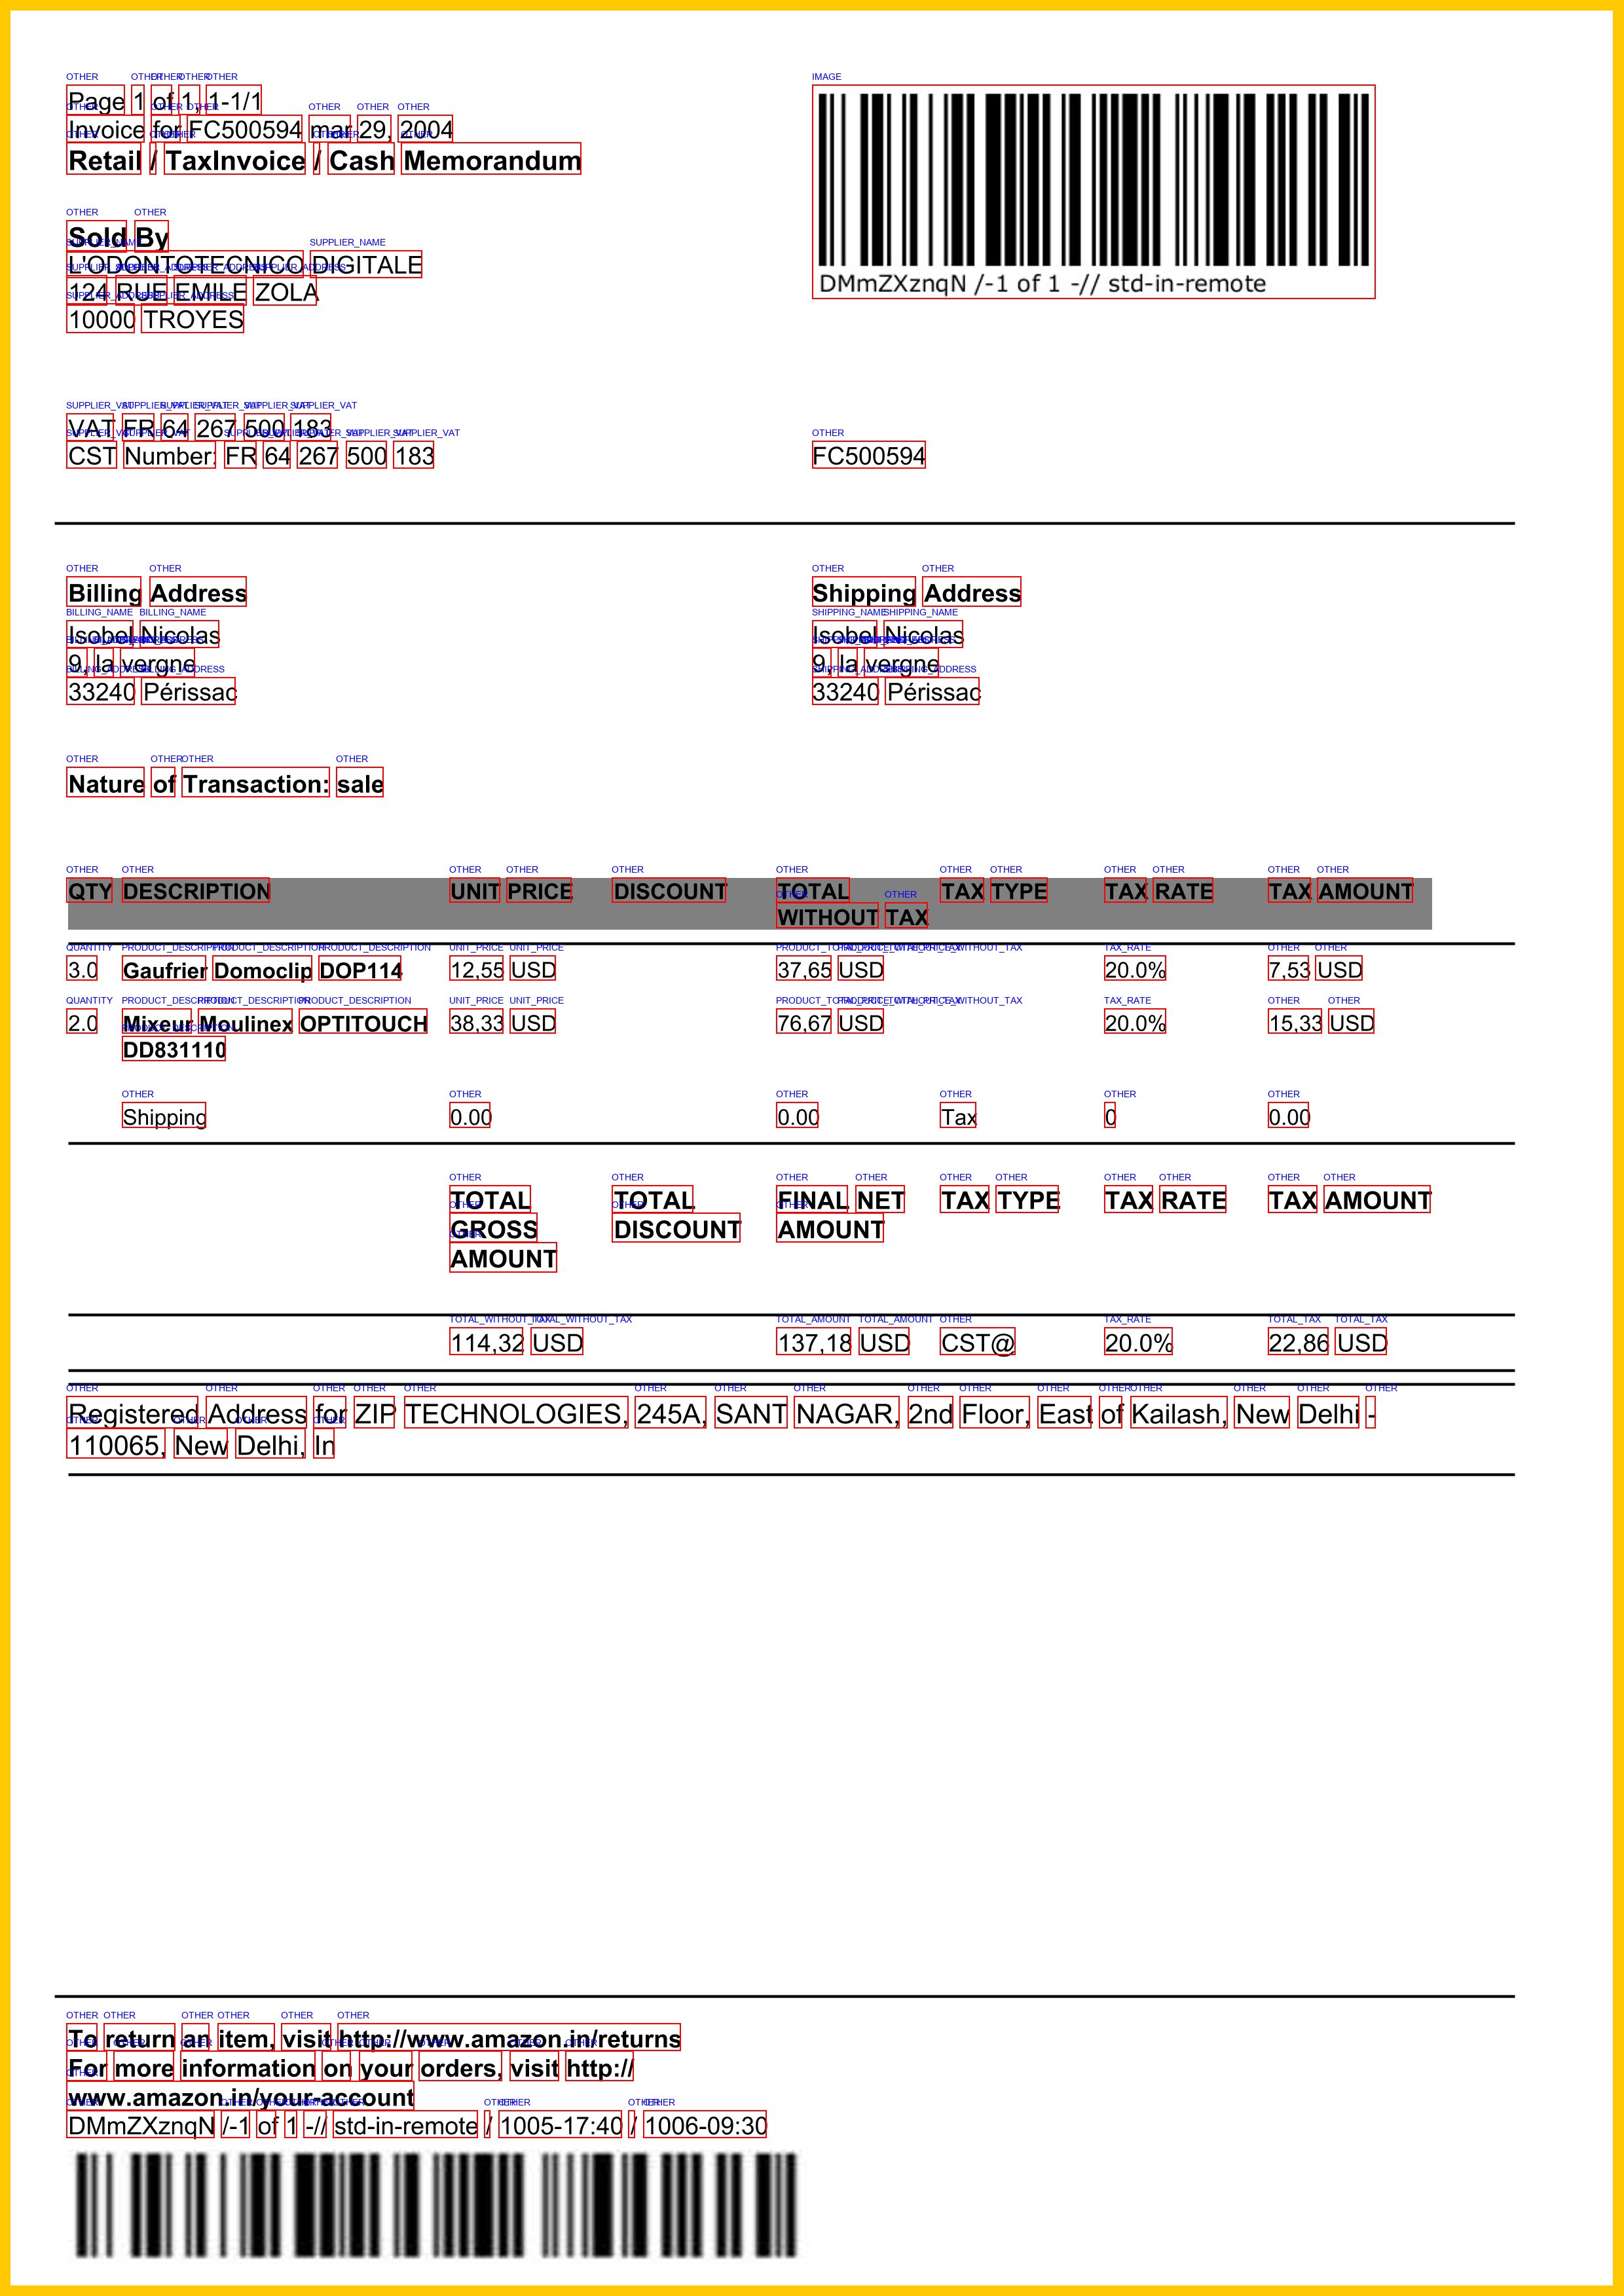

In [27]:
# Show predictons
image = Image.open(os.path.join(data_dir,'synthetic_invoice/test/image/', test.iloc[sample_idx].file))
image = image.convert("RGB")

draw = ImageDraw.Draw(image)
font = ImageFont.truetype("arial.ttf", size=14)

for idx, row in df.iterrows():
    bbox = unnormalize_bbox(row['bbox'], 2480, 3508)

    draw.rectangle(bbox, outline='red', width=2)
    draw.text((bbox[0], bbox[1] - 20), text=row['target_predicted'], fill='blue', font=font)

image